<a href="https://colab.research.google.com/github/vijishmadhavan/ArtLine/blob/main/ControlNet_%2BArtLine_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title ## **From https://github.com/vijishmadhavan/ArtLine/tree/main/Lineart_Color**

In [1]:
#@title ## Installing ArtLine Dependencies
%%capture

!wget https://www.dropbox.com/s/m9ma320rapswk2z/requirements.txt
!pip install -r requirements.txt

In [2]:
#@title ##  Clone ControlNet
#@markdown Clone ControlNet from GitHub and check for updates. Use textbox below if you want to checkout other branch or old commit. Leave it empty to stay the HEAD on main.
%%capture

import os
%store -r

!nvidia-smi

root_dir = "/content"
%store root_dir
repo_dir = str(root_dir)+"/ControlNet"
%store repo_dir
models_dir = str(root_dir)+"/ControlNet/models"
%store models_dir


branch = "" #@param {type: "string"}
repo_url = "https://github.com/lllyasviel/ControlNet"

def clone_repo():
  if os.path.isdir(repo_dir):
    print("The repository folder already exists, will do a !git pull instead\n")
    %cd {repo_dir}
    !git pull origin {branch} if branch else !git pull
  else:
    %cd {root_dir}
    !git clone {repo_url} {repo_dir}

if not os.path.isdir(repo_dir):
  clone_repo()

%cd {root_dir}
os.makedirs(repo_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

if branch:
  %cd {repo_dir}
  status = os.system(f"git checkout {branch}")
  if status != 0:
    raise Exception("Failed to checkout branch or commit")

In [3]:
#@title ## Installing Dependencies
#@markdown This will install required Python packages
%%capture

import os
%store -r

install_xformers = True #@param {'type':'boolean'}

%cd {repo_dir}

def install_dependencies():
    if install_xformers:
        !pip install gradio -q #gradio isn't required to be mentioned on requirements for apps on HF space
        !sudo apt-get install aria2
        !pip install timm==0.6.12
        !pip install opencv-contrib-python==4.3.0.36
        !pip install pytorch-lightning==1.9.1
        !pip install einops==0.3.0
        !pip install open_clip_torch==2.0.2
        !pip install omegaconf==2.1.1
        !pip install transformers==4.19.2
        !pip install xformers --no-cache-dir
        !pip install --pre -U triton
        !sudo apt-get install aria2
        !sed -i "s@block.launch(server_name='0.0.0.0')@block.launch(debug=True, share=True)@" /content/ControlNet/gradio_canny2image.py
        !sed -i "s@block.launch(server_name='0.0.0.0')@block.launch(debug=True, share=True)@" /content/ControlNet/gradio_annotator.py
        !sed -i "s@block.launch(server_name='0.0.0.0')@block.launch(debug=True, share=True)@" /content/ControlNet/gradio_depth2image.py
        !sed -i "s@block.launch(server_name='0.0.0.0')@block.launch(debug=True, share=True)@" /content/ControlNet/gradio_fake_scribble2image.py
        !sed -i "s@block.launch(server_name='0.0.0.0')@block.launch(debug=True, share=True)@" /content/ControlNet/gradio_hed2image.py
        !sed -i "s@block.launch(server_name='0.0.0.0')@block.launch(debug=True, share=True)@" /content/ControlNet/gradio_hough2image.py
        !sed -i "s@block.launch(server_name='0.0.0.0')@block.launch(debug=True, share=True)@" /content/ControlNet/gradio_normal2image.py
        !sed -i "s@block.launch(server_name='0.0.0.0')@block.launch(debug=True, share=True)@" /content/ControlNet/gradio_pose2image.py
        !sed -i "s@block.launch(server_name='0.0.0.0')@block.launch(debug=True, share=True)@" /content/ControlNet/gradio_scribble2image.py
        !sed -i "s@block.launch(server_name='0.0.0.0')@block.launch(debug=True, share=True)@" /content/ControlNet/gradio_seg2image.py
        !sed -i "s@block.launch(server_name='0.0.0.0')@block.launch(debug=True, share=True)@" /content/ControlNet/gradio_scribble2image_interactive.py
        !sed -i "s@save_memory = False@save_memory = True@" /content/ControlNet/config.py

install_dependencies()

In [4]:
%%capture

import os
%store -r

%cd {root_dir}

installModels = []

#@markdown ### Download  Model
modelUrl = "https://huggingface.co/lllyasviel/ControlNet/resolve/main/models/control_sd15_canny.pth"
modelList = ["", "control_sd15_canny"]
modelName = "control_sd15_canny"

if modelName != "":
  installModels.append((modelName, modelUrl))

def install(checkpoint_name, url):
  ext = "pth" if url.endswith(".pth") else "pt"

  hf_token = '' 
  user_header = f"\"Authorization: Bearer {hf_token}\""
  !aria2c --console-log-level=error --summary-interval=10 --header={user_header} -c -x 16 -k 1M -s 16 -d {repo_dir}/models -o {checkpoint_name}.{ext} "{url}"

def install_checkpoint():
  for model in installModels:
    install(model[0], model[1])

install_checkpoint()


In [5]:
#@title ## Download Additional model
%%capture

!aria2c --console-log-level=error --summary-interval=10 --header={user_header} -c -x 16 -k 1M -s 16 -d /content/ControlNet/annotator/ckpts -o body_pose_model.pth "https://huggingface.co/lllyasviel/ControlNet/resolve/main/annotator/ckpts/body_pose_model.pth"
!aria2c --console-log-level=error --summary-interval=10 --header={user_header} -c -x 16 -k 1M -s 16 -d /content/ControlNet/annotator/ckpts -o dpt_hybrid-midas-501f0c75.pt "https://huggingface.co/lllyasviel/ControlNet/resolve/main/annotator/ckpts/dpt_hybrid-midas-501f0c75.pt"
!aria2c --console-log-level=error --summary-interval=10 --header={user_header} -c -x 16 -k 1M -s 16 -d /content/ControlNet/annotator/ckpts -o hand_pose_model.pth "https://huggingface.co/lllyasviel/ControlNet/resolve/main/annotator/ckpts/hand_pose_model.pth"
!aria2c --console-log-level=error --summary-interval=10 --header={user_header} -c -x 16 -k 1M -s 16 -d /content/ControlNet/annotator/ckpts -o mlsd_large_512_fp32.pth "https://huggingface.co/lllyasviel/ControlNet/resolve/main/annotator/ckpts/mlsd_large_512_fp32.pth"
!aria2c --console-log-level=error --summary-interval=10 --header={user_header} -c -x 16 -k 1M -s 16 -d /content/ControlNet/annotator/ckpts -o mlsd_tiny_512_fp32.ptht "https://huggingface.co/lllyasviel/ControlNet/resolve/main/annotator/ckpts/mlsd_tiny_512_fp32.pth"
!aria2c --console-log-level=error --summary-interval=10 --header={user_header} -c -x 16 -k 1M -s 16 -d /content/ControlNet/annotator/ckpts -o network-bsds500.pth "https://huggingface.co/lllyasviel/ControlNet/resolve/main/annotator/ckpts/network-bsds500.pth"
!aria2c --console-log-level=error --summary-interval=10 --header={user_header} -c -x 16 -k 1M -s 16 -d /content/ControlNet/annotator/ckpts -o upernet_global_small.pth "https://huggingface.co/lllyasviel/ControlNet/resolve/main/annotator/ckpts/upernet_global_small.pth"

In [6]:
#@title ## Run 
%%capture

%cd /content/ControlNet
from share import *

import config

import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random
from PIL import Image

from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.canny import CannyDetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler



apply_canny = CannyDetector()

model = create_model('./models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict('./models/control_sd15_canny.pth', location='cuda'))
model = model.cuda()
ddim_sampler = DDIMSampler(model)


def process(input_image, prompt, a_prompt, n_prompt, num_samples, image_resolution, ddim_steps, guess_mode, strength, scale, seed, eta, low_threshold, high_threshold):
    with torch.no_grad():
        img = resize_image(HWC3(input_image), image_resolution)
        H, W, C = img.shape

        detected_map = apply_canny(img, low_threshold, high_threshold)
        detected_map = HWC3(detected_map)

        control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
        un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, verbose=False, eta=eta,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

        results = [x_samples[i] for i in range(num_samples)]
        #show_image(results[0])
        result_image = Image.fromarray(results[0])
        result_image.save("output.jpg")
        return result_image




In [73]:
#@title ## Put Image URL here, try hig-res Images

%cd /content
from PIL import Image
import requests
import numpy as np
import urllib.request
from urllib.request import urlretrieve
import PIL.Image
import torchvision.transforms as T
import fastai
from fastai.vision import *
from fastai.utils.mem import *
from PIL import Image
import numpy as np
from io import BytesIO

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]
 
    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

MODEL_URL = "https://www.dropbox.com/s/starqc9qd2e1lg1/ArtLine_650.pkl?dl=1"
#download if not already downloaded
if not os.path.exists("ArtLine_650.pkl"):
    urllib.request.urlretrieve(MODEL_URL, "ArtLine_650.pkl")
path = Path(".")
learn=load_learner(path, 'ArtLine_650.pkl')

from PIL import Image,ImageOps
import requests
from io import BytesIO

import fastai
from fastai.vision import *
from fastai.utils.mem import *
from fastai.vision import open_image, load_learner, image, torch,Image
import numpy as np
import urllib.request
import PIL.Image
from io import BytesIO
import torchvision.transforms as T

def add_margin2(img, size=650, color=(255, 255, 255)):
    width, height = img.size
    new_width = ((width - 1) // size + 1) * size
    new_height = ((height - 1) // size + 1) * size
    left = (new_width - width) // 2
    top = (new_height - height) // 2
    right = new_width - width - left
    bottom = new_height - height - top
    return ImageOps.expand(img, border=(left, top, right, bottom), fill=color)
def add_margin(img, size=650, color=(255, 255, 255)):
    width, height = img.size
    max_dim = max(width, height)
    new_dim = ((max_dim - 1) // size + 1) * size
    h_pad = (new_dim - height) // 2
    w_pad = (new_dim - width) // 2
    border = (w_pad, h_pad, w_pad, h_pad)
    return ImageOps.expand(img, border=border, fill=color)
def predict(url):
    response = requests.get(url)
    img = PIL.Image.open(BytesIO(response.content)).convert("RGB")
    img_with_margin = add_margin(img)
    #img_with_margin.save("test2.png")

    img_t = T.ToTensor()(img_with_margin)
    img_fast = Image(img_t)
    p,img_hr,b = learn.predict(img_fast)
  
    x = np.minimum(np.maximum(image2np(img_hr.data*255), 0), 255).astype(np.uint8)
    img_hr = PIL.Image.fromarray(x)
    img_hr = img_hr.resize(img_with_margin.size)  
  
    # Remove margin from the high-resolution image
    width, height = img.size
    left = (img_with_margin.size[0] - width) // 2
    top = (img_with_margin.size[1] - height) // 2
    img_hr = img_hr.crop((left, top, left + width, top + height))
  
    img_hr.save("test.png")

def predict2(url):
  response = requests.get(url)
  input = PIL.Image.open(BytesIO(response.content)).convert("RGB")
  size = input.size
  img_t = T.ToTensor()(input)
  img_fast = Image(img_t)
  p,img_hr,b = learn.predict(img_fast)
  x = np.minimum(np.maximum(image2np(img_hr.data*255), 0), 255).astype(np.uint8)
  img = PIL.Image.fromarray(x)
  #im = img.resize(size)
  img.save("test.png")


url = 'https://media.pitchfork.com/photos/62aca4ab05e78100734f4508/3:4/w_750,h_1000,c_limit/TakeawaysDrake%20(1).jpg' #@param {type:"string"}
predict(url)

/content


In [76]:
#@title ## Prompt

prompt = "Old school rapper in the style of 90's vintage anime, surrealism, akira style. detailed line art. fine details. inside a 7/11 in tokyo" #@param {type:"string"}

INFO:lightning_fabric.utilities.seed:Global seed set to 33274


Data shape for DDIM sampling is (1, 4, 88, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


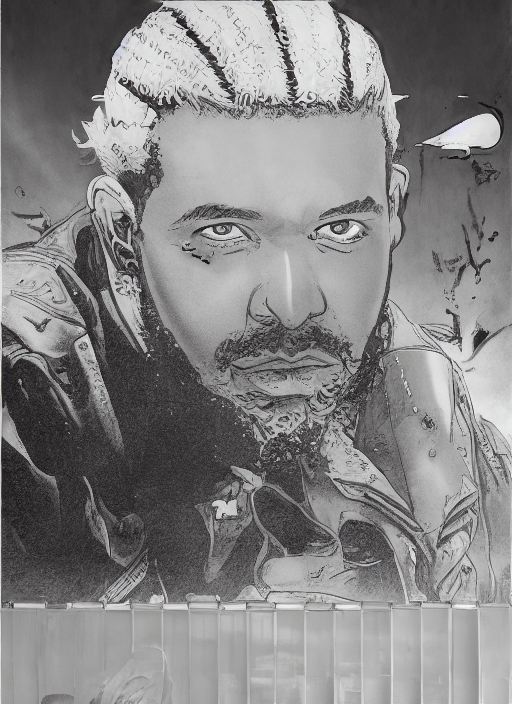

In [77]:

#@title ## Show Color
from PIL import Image

import cv2

# Load the image
input_image = cv2.imread('/content/test.png')
# Define the default arguments
a_prompt = "best quality, extremely detailed"
n_prompt = "longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality"
num_samples = 1
image_resolution = 512
ddim_steps = 20
guess_mode = False
strength = 1.0
scale = 6.0
seed = -1
eta = 0.0
low_threshold = 50
high_threshold = 60

# Call the process function with the arguments
process(input_image, prompt, a_prompt, n_prompt, num_samples, image_resolution, ddim_steps, guess_mode, strength, scale, seed, eta, low_threshold, high_threshold)
